# Analisando as vendas da empresa
- Vamos utilizar a base disponível em:
    - https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce?select=olist_customers_dataset.csv
    - Essa é uma base de dados real, porém anonimizada.
- Fizemos alguns tratamentos nos dados e disponibilizamos em arquivos:
    - `base_vendas.xlxs` - todos os dados de venda por item da empresa, onde cada linha representa 1 item vendido.
    - `verifica_base.xlxs` - base com as categorias dos produtos.
- Utilizaremos três modelos de aprendizado de máquina para verificar qual deles apresenta o melhor desempenho.

In [1]:
# Importando as bibliotecas
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn import svm
from sklearn.metrics import mean_absolute_error
from joblib import dump

In [2]:
# Importando a base de vendas
vendas = pd.read_excel('base_vendas.xlsx')

In [3]:
# Visualizando a base
vendas.head(3)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,...,price,freight_value,product_category_name,customer_unique_id,customer_city,customer_state,dia_compra,mes_compra,ano_compra,ano_mes
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02,2017-10-02,2017-10-04,2017-10-10,2017-10-18,1.0,87285b34884572647811a353c7ac498a,...,29.99,8.72,utilidades_domesticas,7c396fd4830fd04220f754e42b4e5bff,sao paulo,SP,2,10,2017,2017-10
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24,2018-07-26,2018-07-26,2018-08-07,2018-08-13,1.0,595fac2a385ac33a80bd5114aec74eb8,...,118.70,22.76,perfumaria,af07308b275d755c9edb36a90c618231,barreiras,BA,24,7,2018,2018-07
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08,2018-08-08,2018-08-08,2018-08-17,2018-09-04,1.0,aa4383b373c6aca5d8797843e5594415,...,159.90,19.22,automotivo,3a653a41f6f9fc3d2a113cf8398680e8,vianopolis,GO,8,8,2018,2018-08


In [4]:
# Verificando as informações da base
vendas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111923 entries, 0 to 111922
Data columns (total 22 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       111923 non-null  object        
 1   customer_id                    111923 non-null  object        
 2   order_status                   111923 non-null  object        
 3   order_purchase_timestamp       111923 non-null  datetime64[ns]
 4   order_approved_at              111808 non-null  datetime64[ns]
 5   order_delivered_carrier_date   110050 non-null  datetime64[ns]
 6   order_delivered_customer_date  108804 non-null  datetime64[ns]
 7   order_estimated_delivery_date  111923 non-null  datetime64[ns]
 8   order_item_id                  111206 non-null  float64       
 9   product_id                     111206 non-null  object        
 10  seller_id                      111206 non-null  object        
 11  

In [5]:
# Também analisando as informações estatísticas
vendas.describe()

,order_item_id,price,freight_value,dia_compra,mes_compra,ano_compra
count,111206.000000,111206.000000,111206.000000,111923.000000,111923.000000,111923.000000
mean,1.198020,120.845955,20.032079,15.512853,6.000670,2017.541167
std,0.706445,183.941756,15.847991,8.667442,3.241051,0.498305
min,1.000000,0.850000,0.000000,1.000000,1.000000,2017.000000
25%,1.000000,39.900000,13.080000,8.000000,3.000000,2017.000000
50%,1.000000,74.990000,16.280000,15.000000,6.000000,2018.000000
75%,1.000000,134.990000,21.180000,23.000000,8.000000,2018.000000
max,21.000000,6735.000000,409.680000,31.000000,12.000000,2018.000000


In [6]:
# Importando a base de grupos
grupos = pd.read_excel('verifica_base.xlsx')
grupos.head(3)

,categoria,grupo
0,agro_industria_e_comercio,outros
1,alimentos,outros
2,alimentos_bebidas,outros


In [7]:
# Podemos unir essas duas bases utilizando o merge
vendas = pd.merge(vendas, 
                  grupos, 
                  how='left', 
                  left_on='product_category_name',
                  right_on='categoria')

In [8]:
# E também apagar as colunas que não estamos usando
vendas = vendas.drop(['product_category_name','categoria'],axis=1)

In [9]:
# Verificando as informações da tabela
vendas.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 111923 entries, 0 to 111922
Data columns (total 22 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       111923 non-null  object        
 1   customer_id                    111923 non-null  object        
 2   order_status                   111923 non-null  object        
 3   order_purchase_timestamp       111923 non-null  datetime64[ns]
 4   order_approved_at              111808 non-null  datetime64[ns]
 5   order_delivered_carrier_date   110050 non-null  datetime64[ns]
 6   order_delivered_customer_date  108804 non-null  datetime64[ns]
 7   order_estimated_delivery_date  111923 non-null  datetime64[ns]
 8   order_item_id                  111206 non-null  float64       
 9   product_id                     111206 non-null  object        
 10  seller_id                      111206 non-null  object        
 11  

In [10]:
# Visualizando itens da base que são nulos
vendas.isnull().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 115
order_delivered_carrier_date     1873
order_delivered_customer_date    3119
order_estimated_delivery_date       0
order_item_id                     717
product_id                        717
seller_id                         717
shipping_limit_date               717
price                             717
freight_value                     717
customer_unique_id                  0
customer_city                       0
customer_state                      0
dia_compra                          0
mes_compra                          0
ano_compra                          0
ano_mes                             0
grupo                            2315
dtype: int64

In [11]:
# Retirando os valores onde o preço é vazio
vendas = vendas[vendas.price.notnull()]

In [12]:
# Retirando as vendas que foram canceladas
vendas = vendas[vendas.order_status != 'canceled']

In [13]:
# Retirando o dia "black friday"
vendas = vendas[vendas.order_purchase_timestamp != dt.datetime(2017,11,24)]

In [14]:
# Retirando o dia após a "black friday"
vendas = vendas[vendas.order_purchase_timestamp != dt.datetime(2017,11,25)]

In [15]:
# Substituindo valores vazios no grupo por "outros"
vendas.loc[vendas.grupo.isnull(),'grupo'] = 'outros'

In [16]:
# Contando quantos valores nulod/vazios existem em cada coluna
vendas.isnull().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                  15
order_delivered_carrier_date      688
order_delivered_customer_date    1845
order_estimated_delivery_date       0
order_item_id                       0
product_id                          0
seller_id                           0
shipping_limit_date                 0
price                               0
freight_value                       0
customer_unique_id                  0
customer_city                       0
customer_state                      0
dia_compra                          0
mes_compra                          0
ano_compra                          0
ano_mes                             0
grupo                               0
dtype: int64

In [17]:
# Entendendo as 15 colunas com order_approved_at vazias
vendas[vendas.order_approved_at.isnull()]

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,...,price,freight_value,customer_unique_id,customer_city,customer_state,dia_compra,mes_compra,ano_compra,ano_mes,grupo
5909,e04abd8149ef81b95221e88f6ed9ab6a,2127dc6603ac33544953ef05ec155771,delivered,2017-02-18,NaT,2017-02-23,2017-03-01,2017-03-17,1.0,0e20a07ca1714df21f9b07ca3bf7c682,...,309.90,39.11,8a9a08c7ca8900a200d83cf838a07e0b,cotia,SP,18,2,2017,2017-02,eletro_eletronicos
18599,8a9adc69528e1001fc68dd0aaebbb54a,4c1ccc74e00993733742a3c786dc3c1f,delivered,2017-02-18,NaT,2017-02-23,2017-03-02,2017-03-21,1.0,2c2b6a28924791234bd386bddb17512e,...,379.00,17.86,91efb7fcabc17925099dced52435837f,novo hamburgo,RS,18,2,2017,2017-02,construção
21347,7013bcfc1c97fe719a7b5e05e61c12db,2941af76d38100e0f8740a374f1a5dc3,delivered,2017-02-18,NaT,2017-02-22,2017-03-01,2017-03-17,1.0,583916a5dae918f5e89baec139141c54,...,49.99,15.53,e1f01a1bd6485e58ad3c769a5427d8a8,sao paulo,SP,18,2,2017,2017-02,outros
25425,5cf925b116421afa85ee25e99b4c34fb,29c35fc91fc13fb5073c8f30505d860d,delivered,2017-02-18,NaT,2017-02-22,2017-03-09,2017-03-31,1.0,c6dd917a0be2a704582055949915ab32,...,79.99,26.82,7e1a5ca61b572d76b64b6688b9f96473,caninde,CE,18,2,2017,2017-02,outros
25982,12a95a3c06dbaec84bcfb0e2da5d228a,1e101e0daffaddce8159d25a8e53f2b2,delivered,2017-02-17,NaT,2017-02-22,2017-03-02,2017-03-20,1.0,c6dd917a0be2a704582055949915ab32,...,79.99,15.77,c8822fce1d0bfa7ddf0da24fff947172,macae,RJ,17,2,2017,2017-02,outros
30111,c1d4211b3dae76144deccd6c74144a88,684cb238dc5b5d6366244e0e0776b450,delivered,2017-01-19,NaT,2017-01-25,2017-01-30,2017-03-01,1.0,5ab02ca028398131a5ae91401eb49788,...,39.99,14.52,6ff8b0d7b35d5c945633b8d60165691b,santos,SP,19,1,2017,2017-01,esporte
43022,d69e5d356402adc8cf17e08b5033acfb,68d081753ad4fe22fc4d410a9eb1ca01,delivered,2017-02-19,NaT,2017-02-23,2017-03-02,2017-03-27,1.0,cae2e38942c8489d9d7a87a3f525c06b,...,149.80,13.63,2e0a2166aa23da2472c6a60c4af6f7a6,sao paulo,SP,19,2,2017,2017-02,casa
44195,d77031d6a3c8a52f019764e68f211c69,0bf35cac6cc7327065da879e2d90fae8,delivered,2017-02-18,NaT,2017-02-23,2017-03-02,2017-03-22,1.0,02a79d79e818ad0be36cfc843a6af7ad,...,28.99,10.96,c4c0011e639bdbcf26059ddc38bd3c18,varzea paulista,SP,18,2,2017,2017-02,esporte
54379,7002a78c79c519ac54022d4f8a65e6e8,d5de688c321096d15508faae67a27051,delivered,2017-01-19,NaT,2017-01-27,2017-02-06,2017-03-16,1.0,c3b271f47e73d0c9ccf1b43b7606c705,...,45.90,14.52,d49f3dae6bad25d05160fc17aca5942d,conselheiro lafaiete,MG,19,1,2017,2017-01,casa
69318,2eecb0d85f281280f79fa00f9cec1a95,a3d3c38e58b9d2dfb9207cab690b6310,delivered,2017-02-17,NaT,2017-02-22,2017-03-03,2017-03-20,1.0,4fd676d9c4723d475026e40aeae56957,...,135.00,19.23,5a4fa4919cbf2b049e72be460a380e5b,abaete,MG,17,2,2017,2017-02,construção


In [18]:
# Apagando essa coluna
vendas = vendas.drop('order_approved_at', axis=1)

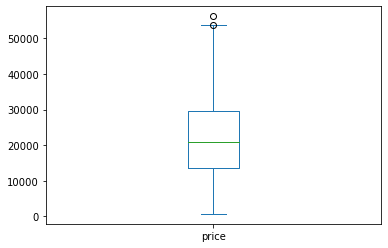

In [19]:
# Criando um boxplot para verificar outlier
vendas.groupby('order_purchase_timestamp')['price'].sum().plot.box();

In [20]:
# Exportando para o Excel
vendas.to_excel('base_vendas_nova.xlsx', index=False)

In [21]:
# Qual vai ser a venda valor nos próximos dias?
vendas.head(3)

,order_id,customer_id,order_status,order_purchase_timestamp,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,...,price,freight_value,customer_unique_id,customer_city,customer_state,dia_compra,mes_compra,ano_compra,ano_mes,grupo
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02,2017-10-04,2017-10-10,2017-10-18,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,...,29.99,8.72,7c396fd4830fd04220f754e42b4e5bff,sao paulo,SP,2,10,2017,2017-10,casa
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24,2018-07-26,2018-08-07,2018-08-13,1.0,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,...,118.70,22.76,af07308b275d755c9edb36a90c618231,barreiras,BA,24,7,2018,2018-07,beleza
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08,2018-08-08,2018-08-17,2018-09-04,1.0,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,...,159.90,19.22,3a653a41f6f9fc3d2a113cf8398680e8,vianopolis,GO,8,8,2018,2018-08,carro


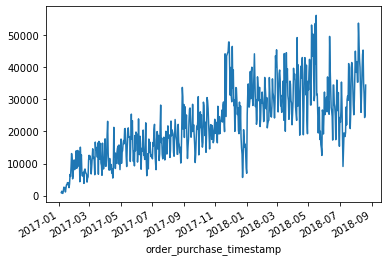

In [22]:
# Visualizando a venda pelo tempo
vendas.groupby('order_purchase_timestamp')['price'].sum().plot();

In [23]:
# Podemos criar uma nova variável para a venda por dia
vendas_vlr = vendas.groupby('order_purchase_timestamp')['price'].sum()

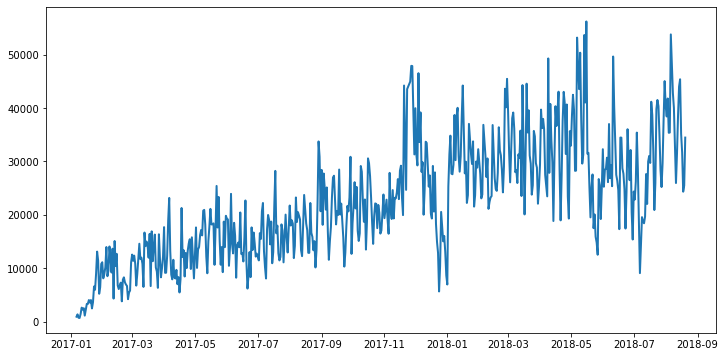

In [24]:
# E então traçar o gráfico dessa variável
fig, ax = plt.subplots(figsize=(12,6))

x = vendas_vlr.index
y = vendas_vlr.values

ax.plot(x, y, linewidth=2.0)

plt.show()

In [25]:
# Verificar a data da última informação na tabela
vendas_vlr.index[-1]

Timestamp('2018-08-20 00:00:00')

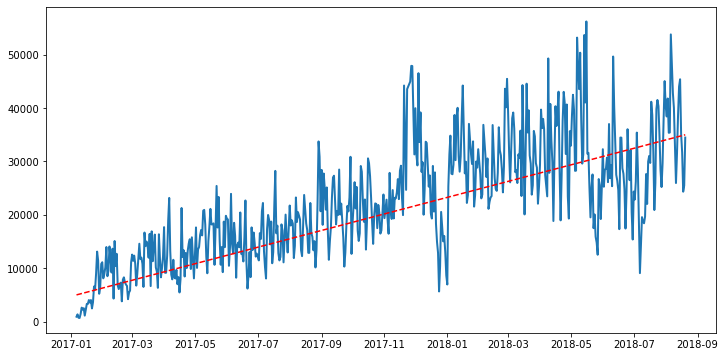

In [26]:
# Eu posso traçar uma reta qualquer para estimar a venda
fig, ax = plt.subplots(figsize=(12,6))

x = vendas_vlr.index
y = vendas_vlr.values

ax.plot(x, y, linewidth=2.0)

x_reta = [vendas_vlr.index[0], vendas_vlr.index[-1]]
y_reta = [5000, 35000]

ax.plot(x_reta, y_reta, '--r')

plt.show()

In [27]:
# Ajustando a vendas_vlr como um Dataframe
vendas_vlr = vendas_vlr.reset_index()
vendas_vlr

,order_purchase_timestamp,price
0,2017-01-06,916.38
1,2017-01-07,1351.90
2,2017-01-08,709.58
3,2017-01-09,673.79
4,2017-01-10,1434.87
...,...,...
585,2018-08-16,35166.77
586,2018-08-17,31683.18
587,2018-08-18,24340.95
588,2018-08-19,25487.39


In [28]:
# Antes de usar o Scikit-Learn, vamos tratar a data para conseguir colocar no modelo

In [29]:
vendas_vlr.tail(3)

,order_purchase_timestamp,price
587,2018-08-18,24340.95
588,2018-08-19,25487.39
589,2018-08-20,34479.50


In [30]:
# Fazendo a diferença entre o dia atual e o menor dia
vendas_vlr['ajuste_data'] = (vendas_vlr.order_purchase_timestamp - vendas_vlr.order_purchase_timestamp.min()).dt.days
vendas_vlr.tail()

,order_purchase_timestamp,price,ajuste_data
585,2018-08-16,35166.77,587
586,2018-08-17,31683.18,588
587,2018-08-18,24340.95,589
588,2018-08-19,25487.39,590
589,2018-08-20,34479.50,591


In [31]:
# Colocando esses valores em uma escala de 0 a 1
vendas_vlr['ajuste_data'] = vendas_vlr['ajuste_data']/vendas_vlr['ajuste_data'].max()

In [32]:
# Separando em X e y nossos dados
X = vendas_vlr.ajuste_data.values.reshape(-1,1)
y = vendas_vlr.price

In [33]:
# Colocando nossos dados no modelo de regressão linear
reg = LinearRegression().fit(X, y)

In [34]:
# Verificando o score
reg.score(X, y)

0.5709008152888746

In [35]:
# O coeficiente angular da reta
reg.coef_

array([28684.73033453])

In [36]:
# e o coeficiente linear
reg.intercept_

7921.539493458125

In [37]:
vendas_vlr.head(3)

,order_purchase_timestamp,price,ajuste_data
0,2017-01-06,916.38,0.000000
1,2017-01-07,1351.90,0.001692
2,2017-01-08,709.58,0.003384


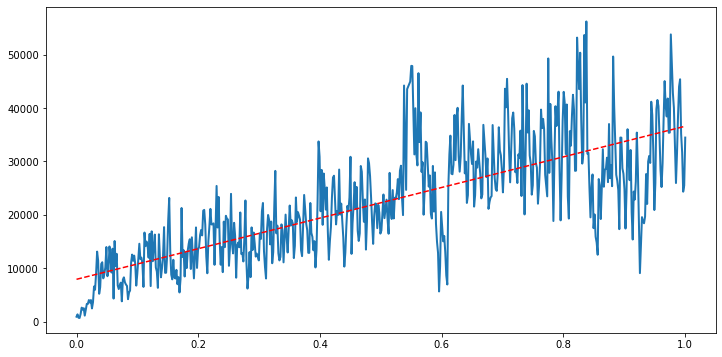

In [38]:
# Podemos adicionar essa reta no gráfico que criamos
fig, ax = plt.subplots(figsize=(12,6))

x = vendas_vlr.ajuste_data
y = vendas_vlr.price

ax.plot(x, y, linewidth=2.0)

x_reta = vendas_vlr.ajuste_data
y_reta = x_reta*reg.coef_[0] + reg.intercept_

ax.plot(x_reta, y_reta, '--r')

plt.show()

In [39]:
# Na verdade eu quero saber  qual a venda de determinados grupo, mais especifcamente
# Visualizando novamente a base de vendas
vendas.head(3)

,order_id,customer_id,order_status,order_purchase_timestamp,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,...,price,freight_value,customer_unique_id,customer_city,customer_state,dia_compra,mes_compra,ano_compra,ano_mes,grupo
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02,2017-10-04,2017-10-10,2017-10-18,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,...,29.99,8.72,7c396fd4830fd04220f754e42b4e5bff,sao paulo,SP,2,10,2017,2017-10,casa
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24,2018-07-26,2018-08-07,2018-08-13,1.0,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,...,118.70,22.76,af07308b275d755c9edb36a90c618231,barreiras,BA,24,7,2018,2018-07,beleza
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08,2018-08-08,2018-08-17,2018-09-04,1.0,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,...,159.90,19.22,3a653a41f6f9fc3d2a113cf8398680e8,vianopolis,GO,8,8,2018,2018-08,carro


In [40]:
# Agupando a venda por grupo
venda_grupos = vendas.groupby(['order_purchase_timestamp', 'grupo'])['price'].sum().reset_index()

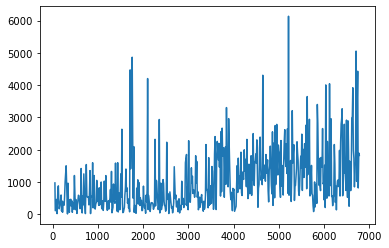

In [41]:
# Visualizando o plot de alguns grupos
venda_grupos.loc[venda_grupos.grupo == 'carro', 'price'].plot();

In [42]:
# Agrupando a venda por data e grupo
venda_grupos = vendas.groupby(['order_purchase_timestamp', 'grupo'])['price'].sum().reset_index()
venda_grupos.tail()

,order_purchase_timestamp,grupo,price
6787,2018-08-20,games,2069.99
6788,2018-08-20,outros,4009.16
6789,2018-08-20,presentes,1939.90
6790,2018-08-20,produtos_diversos,1610.42
6791,2018-08-20,telefonia_audio_video,1101.98


In [43]:
# Verificando a data máxima
venda_grupos.order_purchase_timestamp.max()

Timestamp('2018-08-20 00:00:00')

In [44]:
# E o shape desse DataFrame
venda_grupos.shape
venda_grupos.tail(10)

,order_purchase_timestamp,grupo,price
6782,2018-08-20,casa,7810.46
6783,2018-08-20,construção,2727.83
6784,2018-08-20,crianças,1838.89
6785,2018-08-20,eletro_eletronicos,2621.33
6786,2018-08-20,esporte,939.51
6787,2018-08-20,games,2069.99
6788,2018-08-20,outros,4009.16
6789,2018-08-20,presentes,1939.90
6790,2018-08-20,produtos_diversos,1610.42
6791,2018-08-20,telefonia_audio_video,1101.98


In [45]:
# Podemos então separar os nossos dados em treino e teste
treino = venda_grupos[venda_grupos.order_purchase_timestamp <= dt.datetime(2018, 3, 1)]
teste = venda_grupos[venda_grupos.order_purchase_timestamp > dt.datetime(2018, 3, 1)]

# Verificando o tamanho da base de treino
print(treino.shape)

# Verificando o tamanho da base de teste
print(teste.shape)

# Verificando a proporção de teste da nossa base
print(teste.shape[0]/venda_grupos.shape[0])

(4764, 3)
(2028, 3)
0.29858657243816256


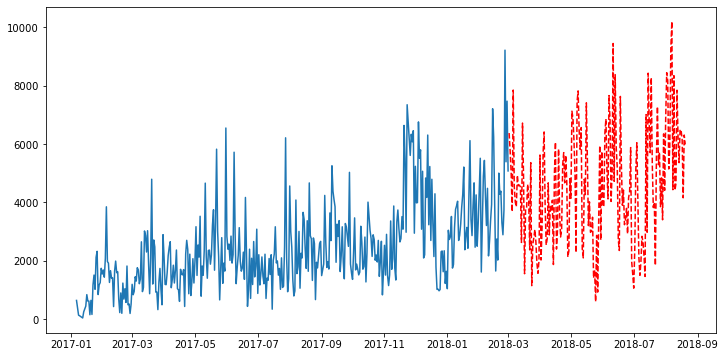

In [46]:
# Podemos então visualizar essa base de treino e de teste
fig, ax = plt.subplots(figsize=(12,6))

filtro = 'beleza'

base_treino = treino[treino.grupo == filtro]
base_teste = teste[teste.grupo == filtro]

ax.plot(base_treino.order_purchase_timestamp, base_treino.price)
ax.plot(base_teste.order_purchase_timestamp, base_teste.price, '--r')

plt.show()

In [47]:
# Visualizando a base de treino
treino.tail(3)

,order_purchase_timestamp,grupo,price
4761,2018-03-01,presentes,2540.77
4762,2018-03-01,produtos_diversos,927.08
4763,2018-03-01,telefonia_audio_video,649.30


In [48]:
# Separando X e y
X_treino = treino[['order_purchase_timestamp', 'grupo']]
y_treino = treino.price
treino.head()

,order_purchase_timestamp,grupo,price
0,2017-01-06,beleza,636.00
1,2017-01-06,crianças,159.99
2,2017-01-06,games,109.90
3,2017-01-06,telefonia_audio_video,10.49
4,2017-01-07,beleza,370.00


In [49]:
# Utilizando o mesmo tratamento que fizemos na data, alterar o datetime por valores em dias
venda_grupos['ajuste_data'] = (venda_grupos.order_purchase_timestamp - venda_grupos.order_purchase_timestamp.min()).dt.days
venda_grupos['ajuste_data'] = venda_grupos['ajuste_data']/venda_grupos['ajuste_data'].max()

treino = venda_grupos[venda_grupos.order_purchase_timestamp <= dt.datetime(2018, 3, 1)]
teste = venda_grupos[venda_grupos.order_purchase_timestamp > dt.datetime(2018, 3, 1)]
venda_grupos.tail()

,order_purchase_timestamp,grupo,price,ajuste_data
6787,2018-08-20,games,2069.99,1.0
6788,2018-08-20,outros,4009.16,1.0
6789,2018-08-20,presentes,1939.90,1.0
6790,2018-08-20,produtos_diversos,1610.42,1.0
6791,2018-08-20,telefonia_audio_video,1101.98,1.0


In [50]:
# Novamente separando X e y
X_treino = treino[['ajuste_data', 'grupo']]
y_treino = treino.price
X_treino.head()

,ajuste_data,grupo
0,0.000000,beleza
1,0.000000,crianças
2,0.000000,games
3,0.000000,telefonia_audio_video
4,0.001692,beleza


In [51]:
# Fazendo o get_dummies para a base de treino, devido não ser possível converter string em float
treino = pd.concat([treino,pd.get_dummies(treino.grupo)],axis=1)
treino.head()

,order_purchase_timestamp,grupo,price,ajuste_data,beleza,carro,casa,construção,crianças,eletro_eletronicos,esporte,games,outros,presentes,produtos_diversos,telefonia_audio_video
0,2017-01-06,beleza,636.00,0.000000,1,0,0,0,0,0,0,0,0,0,0,0
1,2017-01-06,crianças,159.99,0.000000,0,0,0,0,1,0,0,0,0,0,0,0
2,2017-01-06,games,109.90,0.000000,0,0,0,0,0,0,0,1,0,0,0,0
3,2017-01-06,telefonia_audio_video,10.49,0.000000,0,0,0,0,0,0,0,0,0,0,0,1
4,2017-01-07,beleza,370.00,0.001692,1,0,0,0,0,0,0,0,0,0,0,0


In [52]:
# Separando X e y
X_treino = treino.drop(['order_purchase_timestamp', 'grupo', 'price'], axis=1)
y_treino = treino.price
X_treino.head()

,ajuste_data,beleza,carro,casa,construção,crianças,eletro_eletronicos,esporte,games,outros,presentes,produtos_diversos,telefonia_audio_video
0,0.000000,1,0,0,0,0,0,0,0,0,0,0,0
1,0.000000,0,0,0,0,1,0,0,0,0,0,0,0
2,0.000000,0,0,0,0,0,0,0,1,0,0,0,0
3,0.000000,0,0,0,0,0,0,0,0,0,0,0,1
4,0.001692,1,0,0,0,0,0,0,0,0,0,0,0


In [53]:
# E fazendo a regressão linear
reg = LinearRegression().fit(X_treino, y_treino)

In [54]:
# Verificando o score
reg.score(X_treino, y_treino)

0.46798915477922054

In [55]:
# o coeficiente angular
reg.coef_

array([2.94237730e+03, 1.62932632e+16, 1.62932632e+16, 1.62932632e+16,
       1.62932632e+16, 1.62932632e+16, 1.62932632e+16, 1.62932632e+16,
       1.62932632e+16, 1.62932632e+16, 1.62932632e+16, 1.62932632e+16,
       1.62932632e+16])

In [56]:
# e o coeficiente linear
reg.intercept_

-1.6293263192920528e+16

In [57]:
# Salvando na base de treino a previsao que acabamos de fazer
treino['previsao'] = reg.predict(X_treino)

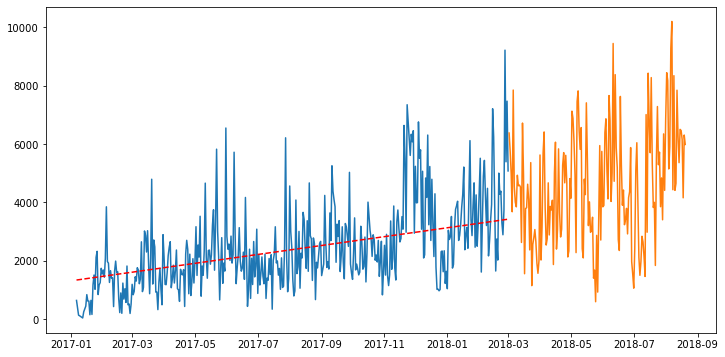

In [58]:
# Podemos então visualizar essa base de treino e teste
fig, ax = plt.subplots(figsize=(12,6))

filtro = 'beleza'

base_treino = treino[treino.grupo == filtro]
base_teste = teste[teste.grupo == filtro]

ax.plot(base_treino.order_purchase_timestamp, base_treino.price)
ax.plot(base_teste.order_purchase_timestamp, base_teste.price)
ax.plot(base_treino.order_purchase_timestamp, base_treino.previsao, '--r')

plt.show()

In [59]:
# Verificando a base de teste
teste.head(3)

,order_purchase_timestamp,grupo,price,ajuste_data
4764,2018-03-02,beleza,6377.81,0.71066
4765,2018-03-02,carro,730.02,0.71066
4766,2018-03-02,casa,6872.26,0.71066


In [60]:
# E a transformação do grupo
teste = pd.concat([teste,pd.get_dummies(teste.grupo)], axis=1)

In [61]:
# Separando X e y
X_teste = teste.drop(['order_purchase_timestamp','grupo','price'], axis=1)
y_teste = teste.price

In [62]:
# E fazendo a previsão para a base de teste
teste['previsao'] = reg.predict(X_teste)

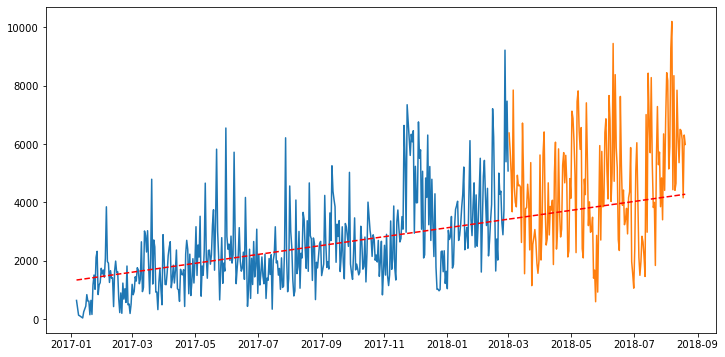

In [63]:
# Podemos então visualizar essa previsão
fig, ax = plt.subplots(figsize=(12,6))

filtro = 'beleza'

base_treino = treino[treino.grupo == filtro]
base_teste = teste[teste.grupo == filtro]

ax.plot(base_treino.order_purchase_timestamp, base_treino.price)
ax.plot(base_teste.order_purchase_timestamp, base_teste.price)
ax.plot(base_treino.order_purchase_timestamp, base_treino.previsao, '--r')
ax.plot(base_teste.order_purchase_timestamp, base_teste.previsao, '--r')

plt.show()

In [64]:
# Verificando novamente a base de venda
vendas.head(3)

,order_id,customer_id,order_status,order_purchase_timestamp,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,...,price,freight_value,customer_unique_id,customer_city,customer_state,dia_compra,mes_compra,ano_compra,ano_mes,grupo
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02,2017-10-04,2017-10-10,2017-10-18,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,...,29.99,8.72,7c396fd4830fd04220f754e42b4e5bff,sao paulo,SP,2,10,2017,2017-10,casa
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24,2018-07-26,2018-08-07,2018-08-13,1.0,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,...,118.70,22.76,af07308b275d755c9edb36a90c618231,barreiras,BA,24,7,2018,2018-07,beleza
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08,2018-08-08,2018-08-17,2018-09-04,1.0,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,...,159.90,19.22,3a653a41f6f9fc3d2a113cf8398680e8,vianopolis,GO,8,8,2018,2018-08,carro


In [65]:
# Agora vamos utilizar as colunas mes_compra e ano_compra
venda_grupos = vendas.groupby(['order_purchase_timestamp','mes_compra', 'ano_compra', 'grupo'])['price'].sum().reset_index()

In [66]:
# Separando em treino e teste
treino = venda_grupos[venda_grupos.order_purchase_timestamp <= dt.datetime(2018,3,1)]
teste = venda_grupos[venda_grupos.order_purchase_timestamp > dt.datetime(2018,3,1)]

In [67]:
# Agora vamos criar novamente o nosso modelo

# Separando X e y para treino
treino = pd.concat([treino, pd.get_dummies(treino.grupo)], axis=1)
X_treino = treino.drop(['order_purchase_timestamp', 'grupo', 'price'], axis=1)
y_treino = treino.price

# Fazendo o fit do modelo
reg = LinearRegression().fit(X_treino, y_treino)

# Fazendo a previsão para a base de treino
treino['previsao'] = reg.predict(X_treino)

# Fazendo a previsão para a base de teste
teste = pd.concat([teste, pd.get_dummies(teste.grupo)], axis=1)
X_teste = teste.drop(['order_purchase_timestamp', 'grupo', 'price'], axis=1)
teste['previsao'] = reg.predict(X_teste)

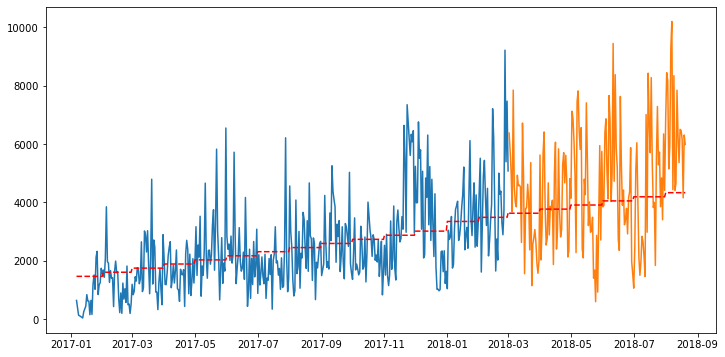

In [68]:
# Visualizando de forma gráfica
fig, ax = plt.subplots(figsize=(12,6))

filtro = 'beleza'

base_treino = treino[treino.grupo == filtro]
base_teste = teste[teste.grupo == filtro]

ax.plot(base_treino.order_purchase_timestamp, base_treino.price)
ax.plot(base_teste.order_purchase_timestamp, base_teste.price)
ax.plot(base_treino.order_purchase_timestamp, base_treino.previsao, '--r')
ax.plot(base_teste.order_purchase_timestamp, base_teste.previsao, '--r')

plt.show()

In [69]:
# Testando a Árvore de Decisão
# Verificando a base de treino
treino.head(3)

,order_purchase_timestamp,mes_compra,ano_compra,grupo,price,beleza,carro,casa,construção,crianças,eletro_eletronicos,esporte,games,outros,presentes,produtos_diversos,telefonia_audio_video,previsao
0,2017-01-06,1,2017,beleza,636.00,1,0,0,0,0,0,0,0,0,0,0,0,1462.0
1,2017-01-06,1,2017,crianças,159.99,0,0,0,0,1,0,0,0,0,0,0,0,309.0
2,2017-01-06,1,2017,games,109.90,0,0,0,0,0,0,0,1,0,0,0,0,-161.0


In [70]:
# Separando X e y de treino
X_treino = treino.drop(['order_purchase_timestamp', 'grupo', 'price', 'previsao'], axis=1)
y_treino = treino.price

In [71]:
# Criando o nosso regressor da árvore de decisão
regressor = DecisionTreeRegressor(random_state=0)

In [72]:
# Fazendo o fit do modelo
regressor.fit(X_treino, y_treino)

DecisionTreeRegressor(random_state=0)

In [73]:
# Verificando o score
regressor.score(X_treino, y_treino)

0.5728847066032111

In [74]:
# Fazendo a previsão pro treino e teste
treino['prev_arvore'] = regressor.predict(X_treino)

X_teste = teste.drop(['order_purchase_timestamp', 'grupo', 'price', 'previsao'], axis=1)
teste['prev_arvore'] = regressor.predict(X_teste)

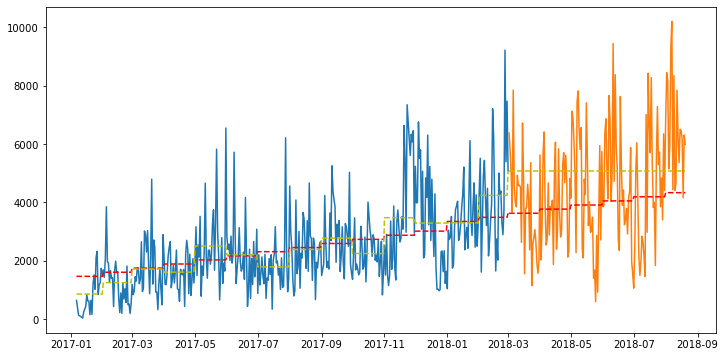

In [75]:
# Adicionando esses dados no gráfico anterior
fig, ax = plt.subplots(figsize=(12,6))

filtro = 'beleza'

base_treino = treino[treino.grupo == filtro]
base_teste = teste[teste.grupo == filtro]

ax.plot(base_treino.order_purchase_timestamp, base_treino.price)
ax.plot(base_teste.order_purchase_timestamp, base_teste.price)
ax.plot(base_treino.order_purchase_timestamp, base_treino.previsao, '--r')
ax.plot(base_teste.order_purchase_timestamp, base_teste.previsao, '--r')
ax.plot(base_treino.order_purchase_timestamp, base_treino.prev_arvore, '--y')
ax.plot(base_teste.order_purchase_timestamp, base_teste.prev_arvore, '--y')

plt.show()

In [76]:
# Analisando o erro na regressão linear
y_true = teste.price
y_pred = teste.previsao
mean_absolute_error(y_true, y_pred)

1428.1206360946744

In [77]:
# Analisando o erro na árvore de decisão
y_true = teste.price
y_pred = teste.prev_arvore
mean_absolute_error(y_true, y_pred)

1515.8149457593688

In [78]:
# Podemos melhorar os parâmetros da árvore de decisão
# Criando o regressor
regressor = DecisionTreeRegressor(random_state=0, max_depth=5)

#Fazendo o fit do modelo
regressor.fit(X_treino,y_treino)

#Fazendo a previsão para a base de teste
y_pred_arvore = regressor.predict(X_teste)

In [79]:
# Analisando o erro na árvore
mean_absolute_error(y_teste, y_pred_arvore)

1410.7095502380175

In [80]:
for i in range(1,20):
    print(i)
    # Criando o regressor
    regressor = DecisionTreeRegressor(random_state=0, max_depth=i)
    
    #Fazendo o fit do modelo
    regressor.fit(X_treino,y_treino)

    #Fazendo a previsão para a base de teste
    y_pred_arvore = regressor.predict(X_teste)
    
    # Analisando o erro na árvore
    print(mean_absolute_error(y_teste, y_pred_arvore))

1
1479.470699932905
2
1350.6020307667957
3
1476.329349434448
4
1389.5748069222627
5
1410.7095502380175
6
1423.0800307126863
7
1349.6478409168199
8
1324.3767520233964
9
1310.715278520996
10
1380.8285512820514
11
1494.6193997256794
12
1487.7440461130382
13
1488.6608166700673
14
1515.8149457593688
15
1515.8149457593688
16
1515.8149457593688
17
1515.8149457593688
18
1515.8149457593688
19
1515.8149457593688


In [81]:
# Criando o regressor
regressor = DecisionTreeRegressor(random_state=0, max_depth=9)
    
#Fazendo o fit do modelo
regressor.fit(X_treino,y_treino)

#Fazendo a previsão para a base de teste
y_pred_arvore = regressor.predict(X_teste)
    
# Analisando o erro na árvore
mean_absolute_error(y_teste, y_pred_arvore)

1310.715278520996

In [82]:
# Criano o nosso regressor suporte a vetores(SVR)
regr = svm.SVR()

In [83]:
# Fazendo o fit do modelo
regr.fit(X_treino, y_treino)

SVR()

In [84]:
# Prevendo para os dados de teste
y_pred_SVR = regr.predict(X_teste)

In [85]:
# Calculando o erro médio absoluto
mean_absolute_error(y_teste, y_pred_SVR)

1791.351285666637

In [86]:
# Fazendo ajustes na base para tentar melhorar o modelo
# Podemos manter apenas alguns grupos
# Verificando novamente o X_treino
X_treino.head(3)

,mes_compra,ano_compra,beleza,carro,casa,construção,crianças,eletro_eletronicos,esporte,games,outros,presentes,produtos_diversos,telefonia_audio_video
0,1,2017,1,0,0,0,0,0,0,0,0,0,0,0
1,1,2017,0,0,0,0,1,0,0,0,0,0,0,0
2,1,2017,0,0,0,0,0,0,0,1,0,0,0,0


In [87]:
# Verificando quais itens mais aparecem nessa base utilizando o .sort_values()
X_treino.sum().sort_values(ascending=False)

ano_compra               9609696
mes_compra                 28552
casa                         417
beleza                       415
esporte                      412
outros                       411
eletro_eletronicos           409
telefonia_audio_video        409
crianças                     407
construção                   406
produtos_diversos            395
carro                        391
presentes                    385
games                        307
dtype: int64

In [88]:
# E se mantivermos apenas as colunas de casa, beleza e esporte?
X_treino2 = X_treino[['mes_compra', 'ano_compra', 'casa', 'beleza', 'esporte']]

In [89]:
# Criando o regressor
regressor2 = DecisionTreeRegressor(random_state=0, max_depth=9)

In [90]:
# Fazendo o fit do modelo
regressor2.fit(X_treino2, y_treino)

DecisionTreeRegressor(max_depth=9, random_state=0)

In [91]:
# Fazendo a previsão para a base de teste
X_teste2 = X_teste[['mes_compra', 'ano_compra', 'casa', 'beleza', 'esporte']]
y_arvore2 = regressor2.predict(X_teste2)

In [92]:
# Analisando o erro na nova árvore
mean_absolute_error(y_teste, y_arvore2)

1496.0288708086784

In [93]:
# Persistindo o modelo
# Importando o joblib
# Fazendo o dump do nosso modelo
dump(regressor, 'regressor_arvore_decisao_teste.joblib')

['regressor_arvore_decisao_teste.joblib']

In [94]:
# Exportando a base de teste para csv
X_teste.to_excel('X_teste.xlsx', index=False)
y_teste.to_excel('y_teste.xlsx', index=False)